In [2]:
import Pkg
Pkg.status()
Pkg.activate()


     Project DeepLearningWithJulia v0.0.1
      Status `~/Desktop/DeepLearningWithJulia/Project.toml`
  [939d5c6b] Books v1.1.4
  [a93c6f00] DataFrames v1.2.2


  [587475ba] 

Flux v0.12.8
  [dbeba491] Metalhead v0.6.1
  [189a3867] Reexport v1.2.2


  Activating environment at `~/.julia/environments/v1.6/Project.toml`


In [3]:
using Metalhead.Images
using Flux, Images
using StatsBase: sample, shuffle
# Inspired by: https://github.com/FluxML/model-zoo/blob/master/tutorials/transfer_learning/dataloader.jl

using Flux, Metalhead
using Flux: @epochs


In [152]:
const PATH = joinpath("/Users/logankilpatrick/Desktop/train")
const FILES = joinpath.(PATH, readdir(PATH))

if isempty(readdir(PATH))
  error("Empty train folder - perhaps you need to download and extract the kaggle dataset.")
end

const DOGS = filter(x -> occursin("dog", x), FILES)
const CATS = filter(x -> occursin("cat", x), FILES)

function load_batch(batchsize = 10, imagesize = (224,224); path = PATH)
    if ((batchsize % 2) != 0)
      print("Batch size must be an even number")
    end

    # Sample N dog images and N cat images, shuffle, and then combine them into a batch
    imgs_paths = shuffle(vcat(sample(DOGS, Int(batchsize/2)), sample(CATS, Int(batchsize/2))))
    
    # Generate the image label based on the file name
    labels = map(x -> occursin("dog.", x) ? 1 : 0, imgs_paths)
    # Here, dog is set to 1 and cat to 0

    # Convert the text based names to 0 or 1
    labels = Flux.onehotbatch(labels, [0, 1])

    # Load the images
    imgs = Images.load.(imgs_paths)

    # Re-size the images based on imagesize from above (most models use 224 x 224)
    imgs = map(img -> Images.imresize(img, imagesize...), imgs)

    # Change the dimensions of each image, switch to gray scale
    imgs = map(img -> permutedims(channelview(img), (3, 2, 1)), imgs)
    # Result is two 3D arrays representing each image.

    # Concatenate the two images into a single 4D array
    imgs = cat(imgs..., dims = 4)

    # Convert the images to float form and return them along with the labels
    Float32.(imgs), labels
end

# load_batch(10)

load_batch (generic function with 3 methods)

In [5]:
resnet = ResNet().layers;

In [6]:
σ = sigmoid

σ (generic function with 2 methods)

In [105]:
model = Chain(
  resnet[1:end-2],
  Dense(2048, 1000),  
  Dense(1000, 256),
  Dense(256, 2),
  softmax        
);


In [153]:
# Create a dataset with 10 batches
dataset = [(load_batch(10)) for i in 1:10];

In [107]:
opt = ADAM()
loss(x,y) = Flux.Losses.logitcrossentropy(model(x), y)

loss (generic function with 1 method)

In [108]:
ps = Flux.params(model[2:end])  # Train only the new dense layers

Params([Float32[-0.01164607 -0.0050571635 … -0.012812835 0.010270205; -0.038513165 -0.006806117 … -0.023871258 -0.022868855; … ; -0.022871986 0.0091891335 … -0.024877068 -0.024609156; 0.01631745 0.011916773 … 0.03825595 -0.03256157], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float32[0.028776817 0.06533238 … 0.028844494 0.044804238; -0.04124853 0.067636326 … 0.01974874 -0.024804974; … ; -0.047591317 0.04719054 … 0.045073714 0.06116166; -0.015413692 0.063599594 … 0.026829489 0.036346406], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float32[-0.0878791 -0.08700882 … -0.008532902 0.028654018; 0.052923314 0.026066894 … 0.14863709 0.013969115], Float32[0.0, 0.0]])

In [109]:
# Update the weights for the layers defined in ps
@epochs 2 Flux.train!(loss, ps, dataset, opt)

┌ Info: Epoch 1
└ @ Main /Users/logankilpatrick/.julia/packages/Flux/ZnXxS/src/optimise/train.jl:138


┌ Info: Epoch 2
└ @ Main /Users/logankilpatrick/.julia/packages/Flux/ZnXxS/src/optimise/train.jl:138


In [110]:
imgs, labels = load_batch(2)
display(model(imgs))

["/Users/logankilpatrick/Desktop/train/cat.10545.jpg", "/Users/logankilpatrick/Desktop/train/dog.4955.jpg"]

2×2 Matrix{Float32}:
 0.0  0.0
 1.0  1.0

In [111]:
size(imgs[:, :, :, 2])

(224, 224, 3)

In [112]:
# IJulia.display(imgs[:, :, :, 1][:, :, 1])
imgs, labels = load_batch(2)
img1 = cat(imgs[:, :, :, 2]; dims = ndims(imgs[:, :, :, 2]) + 1) # Re-shape the image to add an extra dim since there's only one image
img2 = cat(imgs[:, :, :, 1]; dims = ndims(imgs[:, :, :, 1]) + 1) # Re-shape the image to add an extra dim since there's only one image
model(img2)
# The first image from the model is always a cat and the 2nd is always a dog.

["/Users/logankilpatrick/Desktop/train/dog.2118.jpg", "/Users/logankilpatrick/Desktop/train/cat.5013.jpg"]

2×1 Matrix{Float32}:
 0.0
 1.0

In [113]:
model(img1)

2×1 Matrix{Float32}:
 0.0
 1.0

In [114]:
imgs, labels = load_batch(4)
img1 = cat(imgs[:, :, :, 3]; dims = ndims(imgs[:, :, :, 3]) + 1) # Re-shape the image to add an extra dim since there's only one image
img2 = cat(imgs[:, :, :, 4]; dims = ndims(imgs[:, :, :, 4]) + 1) # Re-shape the image to add an extra dim since there's only one image
model(img2)

["/Users/logankilpatrick/Desktop/train/dog.4941.jpg", "/Users/logankilpatrick/Desktop/train/dog.6441.jpg", "/Users/logankilpatrick/Desktop/train/cat.4059.jpg", "/Users/logankilpatrick/Desktop/train/cat.1914.jpg"]

2×1 Matrix{Float32}:
 0.0
 1.0

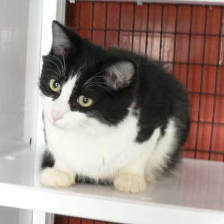

In [115]:
x = Images.load("/Users/logankilpatrick/Desktop/train/cat.7395.jpg")
x = Images.imresize(x, (224,224)...)

In [116]:
# Switch to the size and color channel 
x = permutedims(channelview(x), (3,2,1))

224×224×3 Array{N0f8,3} with eltype N0f8:
[:, :, 1] =
 0.706  0.706  0.706  0.706  0.71   …  0.647  0.647  0.647  0.647  0.647
 0.706  0.706  0.706  0.706  0.71      0.647  0.647  0.647  0.647  0.647
 0.706  0.706  0.706  0.706  0.71      0.647  0.647  0.647  0.647  0.647
 0.706  0.706  0.706  0.706  0.71      0.647  0.647  0.647  0.647  0.647
 0.714  0.714  0.714  0.714  0.714     0.647  0.643  0.643  0.643  0.643
 0.718  0.718  0.718  0.718  0.718  …  0.643  0.639  0.639  0.639  0.639
 0.71   0.71   0.71   0.71   0.71      0.643  0.639  0.639  0.639  0.639
 0.702  0.702  0.702  0.702  0.702     0.643  0.639  0.639  0.639  0.639
 0.698  0.698  0.698  0.698  0.698     0.643  0.639  0.639  0.639  0.639
 0.698  0.698  0.698  0.698  0.698     0.639  0.639  0.639  0.639  0.639
 ⋮                                  ⋱         ⋮                    
 0.882  0.804  0.647  0.588  0.478  …  0.953  0.953  0.957  0.961  0.961
 0.863  0.788  0.655  0.569  0.49      0.953  0.949  0.957  0.965  0.969
 0

In [117]:
x = reshape(x, size(x)..., 1)
float32.(x)

224×224×3×1 Array{Float32, 4}:
[:, :, 1, 1] =
 0.705882  0.705882  0.705882  0.705882  …  0.647059  0.647059  0.647059
 0.705882  0.705882  0.705882  0.705882     0.647059  0.647059  0.647059
 0.705882  0.705882  0.705882  0.705882     0.647059  0.647059  0.647059
 0.705882  0.705882  0.705882  0.705882     0.647059  0.647059  0.647059
 0.713726  0.713726  0.713726  0.713726     0.643137  0.643137  0.643137
 0.717647  0.717647  0.717647  0.717647  …  0.639216  0.639216  0.639216
 0.709804  0.709804  0.709804  0.709804     0.639216  0.639216  0.639216
 0.701961  0.701961  0.701961  0.701961     0.639216  0.639216  0.639216
 0.698039  0.698039  0.698039  0.698039     0.639216  0.639216  0.639216
 0.698039  0.698039  0.698039  0.698039     0.639216  0.639216  0.639216
 ⋮                                       ⋱                      
 0.882353  0.803922  0.647059  0.588235  …  0.956863  0.960784  0.960784
 0.862745  0.788235  0.654902  0.568627     0.956863  0.964706  0.968627
 0.894118  0.

In [140]:
using IJulia
using ImageView

In [147]:
Images.channelview(img)

3×224×224 Array{N0f8,3} with eltype N0f8:
[:, :, 1] =
 0.706  0.706  0.71   0.698  0.698  …  0.624  0.627  0.647  0.706  0.69
 0.706  0.714  0.702  0.698  0.698     0.659  0.627  0.655  0.706  0.706
 0.706  0.718  0.698  0.698  0.698     0.631  0.643  0.686  0.694  0.741

[:, :, 2] =
 0.706  0.706  0.71   0.698  0.698  …  0.322  0.302  0.322  0.373  0.318
 0.706  0.714  0.702  0.698  0.698     0.337  0.314  0.329  0.361  0.333
 0.706  0.718  0.698  0.698  0.698     0.341  0.333  0.357  0.337  0.361

[:, :, 3] =
 0.714  0.714  0.71   0.698  0.698  …  0.388  0.424  0.451  0.451  0.275
 0.714  0.718  0.702  0.698  0.702     0.561  0.439  0.443  0.427  0.306
 0.714  0.718  0.698  0.698  0.706     0.588  0.435  0.459  0.361  0.388

...

[:, :, 222] =
 0.635  0.635  0.635  0.627  0.627  …  0.933  0.933  0.941  0.957  0.965
 0.635  0.635  0.635  0.627  0.631     0.933  0.933  0.957  0.957  0.965
 0.635  0.635  0.635  0.627  0.635     0.933  0.933  0.957  0.965  0.965

[:, :, 223] =
 0.635  0.

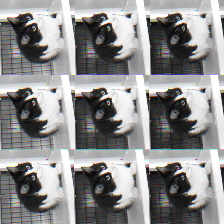

In [144]:
# model(x)
# size(x[:, :, :, 1])
a = x[:, :, :, 1]
img = reshape(a, (3,224,224))
Images.colorview(RGB, img)

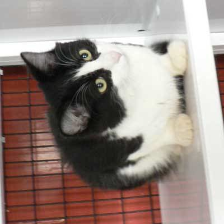

In [150]:
Images.colorview(RGB, permutedims(x[:, :, :, 1], [3,1,2]))